In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
data = pd.read_csv("/content/Coursera.csv")

## EDA

Dataset Shape: (3522, 7)
Columns: Index(['Course Name', 'University', 'Difficulty Level', 'Course Rating',
       'Course URL', 'Course Description', 'Skills'],
      dtype='object')
Sample Data:
                                          Course Name  \
0  Write A Feature Length Screenplay For Film Or ...   
1  Business Strategy: Business Model Canvas Analy...   
2                      Silicon Thin Film Solar Cells   
3                               Finance for Managers   
4       Retrieve Data using Single-Table SQL Queries   

                  University Difficulty Level Course Rating  \
0  Michigan State University         Beginner           4.8   
1   Coursera Project Network         Beginner           4.8   
2        �cole Polytechnique         Advanced           4.1   
3       IESE Business School     Intermediate           4.8   
4   Coursera Project Network         Beginner           4.6   

                                          Course URL  \
0  https://www.coursera.org/lea

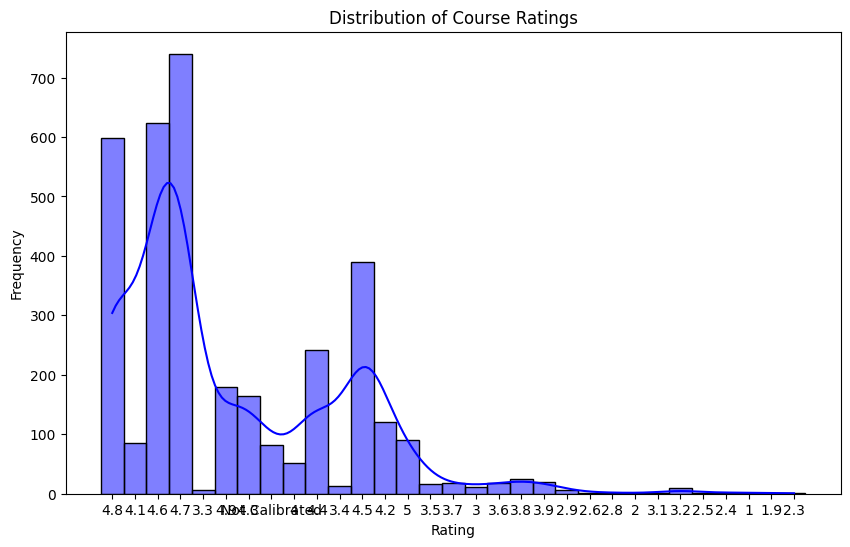

<ipython-input-30-6708da574883>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Difficulty Level'].dropna(), palette='viridis')


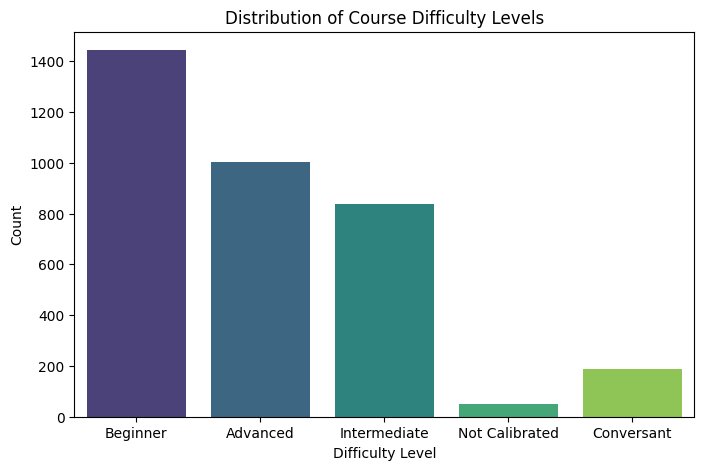

In [30]:
# Exploratory Data Analysis (EDA)
# 1. Overview of the data
print("Dataset Shape:", data.shape)
print("Columns:", data.columns)
print("Sample Data:\n", data.head())

# 2. Checking for missing values
missing_summary = data.isnull().sum()
print("Missing Values:\n", missing_summary)

# 3. Data type summary
print("Data Types:\n", data.dtypes)

# 4. Descriptive statistics
print("Descriptive Statistics:\n", data.describe(include='all'))

# 5. Visualizing the distribution of course ratings
if 'Course Rating' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Course Rating'].dropna(), kde=True, bins=20, color='blue')
    plt.title('Distribution of Course Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()

# 6. Visualizing the distribution of course difficulty levels
if 'Difficulty Level' in data.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=data['Difficulty Level'].dropna(), palette='viridis')
    plt.title('Distribution of Course Difficulty Levels')
    plt.xlabel('Difficulty Level')
    plt.ylabel('Count')
    plt.show()

## Data Preprocessing

In [31]:
# Data Preprocessing
# 1. Handling missing values
# Fill missing ratings with the mean rating
# Assuming 'Course Rating' is the column causing the issue
# Convert 'Course Rating' to numeric, handling errors
data['Course Rating'] = pd.to_numeric(data['Course Rating'], errors='coerce')

# Fill missing ratings with the mean rating
if 'Course Rating' in data.columns:
    data['Course Rating'].fillna(data['Course Rating'].mean(), inplace=True)

# Fill missing text-based fields with an empty string
text_columns = ['Skills', 'Course Description']
for col in text_columns:
    if col in data.columns:
        data[col].fillna('', inplace=True)

# 2. Encoding difficulty levels
if 'Difficulty Level' in data.columns:
    difficulty_mapping = {'beginner': 1, 'intermediate': 2, 'advanced': 3}
    data['Difficulty Level Encoded'] = data['Difficulty Level'].map(difficulty_mapping)

# 3. Extracting individual skills for analysis
if 'Skills' in data.columns:
    data['Skills List'] = data['Skills'].apply(lambda x: x.split(',') if pd.notnull(x) else [])

# 4. Creating a user-course interaction matrix (synthetic data for demonstration)
users = [f'user_{i}' for i in range(1, 51)]  # 50 synthetic users
courses = data['Course Name'].unique()  # Unique courses
user_course_matrix = pd.DataFrame(np.random.randint(1, 6, size=(len(users), len(courses))),
                                  index=users,
                                  columns=courses)

<ipython-input-31-f11a3b7203e3>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Course Rating'].fillna(data['Course Rating'].mean(), inplace=True)
<ipython-input-31-f11a3b7203e3>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

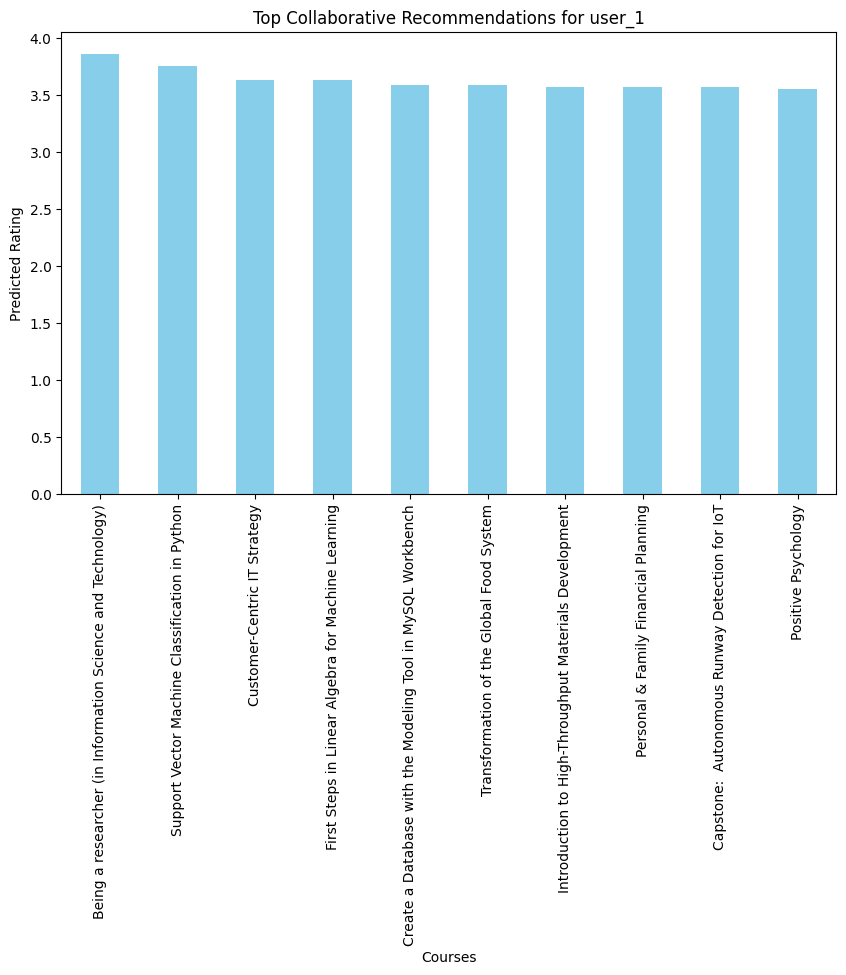

Collaborative Filtering Metrics: Precision=0.39256440281030447, Recall=1.0, F1-Score=0.5638007147361782


In [32]:
# Collaborative Filtering Implementation

def collaborative_filtering(user_course_matrix, target_user):
    # Compute the similarity matrix
    similarity_matrix = cosine_similarity(user_course_matrix)
    similarity_df = pd.DataFrame(similarity_matrix,
                                 index=user_course_matrix.index,
                                 columns=user_course_matrix.index)

    # Find most similar users to the target user
    similar_users = similarity_df[target_user].sort_values(ascending=False).iloc[1:]

    # Weighted average of ratings from similar users
    user_ratings = user_course_matrix.loc[similar_users.index]
    weights = similar_users.values
    recommendations = user_ratings.T.dot(weights) / weights.sum()

    # Sort recommendations
    recommendations = recommendations.sort_values(ascending=False)
    return recommendations

# Select a target user
user_course_matrix = user_course_matrix.astype(float)
target_user = 'user_1'
collab_recommendations = collaborative_filtering(user_course_matrix, target_user)

# Visualize Collaborative Filtering Results
collab_recommendations.head(10).plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title(f'Top Collaborative Recommendations for {target_user}')
plt.xlabel('Courses')
plt.ylabel('Predicted Rating')
plt.show()

# Evaluate Collaborative Filtering
collab_ground_truth = user_course_matrix.loc[target_user].round() > 3
collab_predictions = collab_recommendations.index.isin(collab_ground_truth.index)
collab_precision = precision_score(collab_ground_truth, collab_predictions, average='binary')
collab_recall = recall_score(collab_ground_truth, collab_predictions, average='binary')
collab_f1 = f1_score(collab_ground_truth, collab_predictions, average='binary')

print(f"Collaborative Filtering Metrics: Precision={collab_precision}, Recall={collab_recall}, F1-Score={collab_f1}")









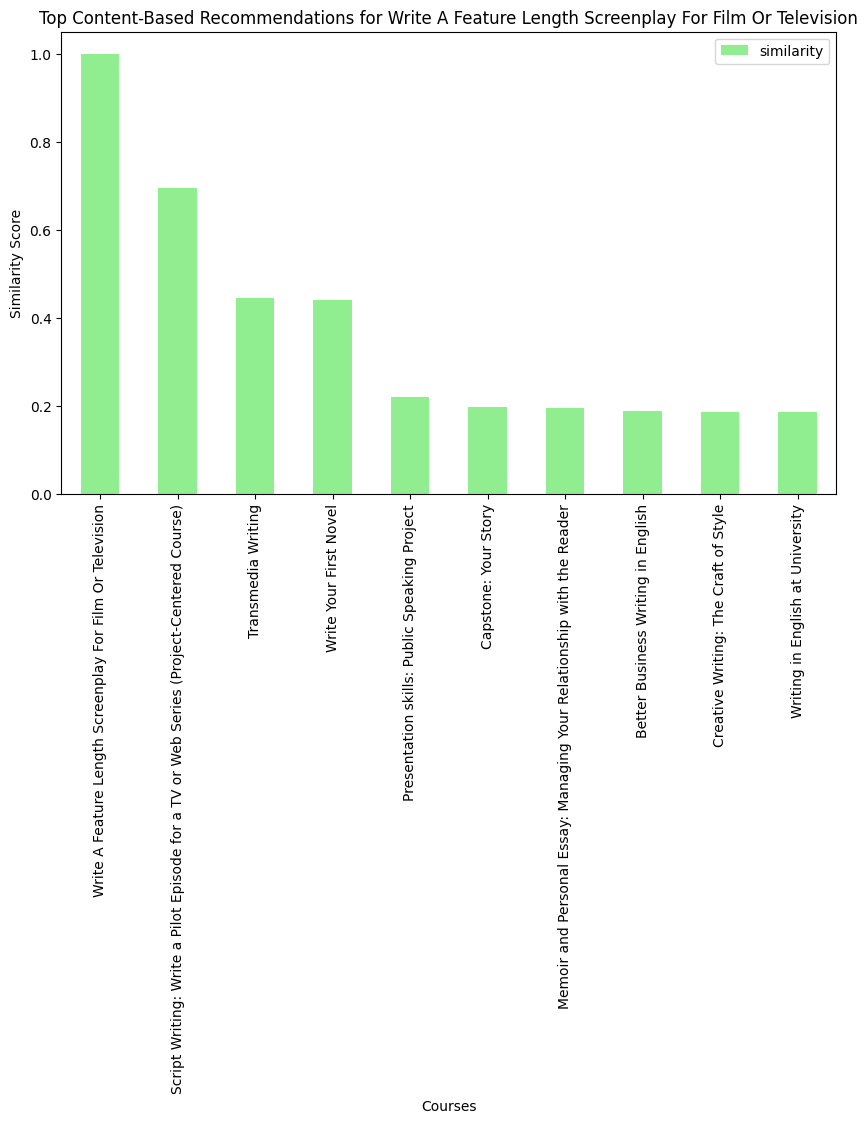

Content-Based Filtering Metrics: Precision=0.39256440281030447, Recall=1.0, F1-Score=0.5638007147361782


In [33]:
# Content-Based Filtering Implementation

def content_based_filtering(data, target_course):
    # Combine relevant text data (skills and course description)
    data['content'] = data['Skills'].fillna('') + ' ' + data['Course Description'].fillna('')

    # Compute TF-IDF matrix
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(data['content'])

    # Compute cosine similarity with the target course
    course_index = data.index[data['Course Name'] == target_course][0]
    similarity_scores = cosine_similarity(tfidf_matrix[course_index], tfidf_matrix).flatten()

    # Get sorted list of recommendations
    data['similarity'] = similarity_scores
    recommendations = data.sort_values(by='similarity', ascending=False)
    return recommendations

# Select a target course
target_course = data['Course Name'].iloc[0]
content_recommendations = content_based_filtering(data, target_course)

# Visualize Content-Based Filtering Results
content_recommendations.head(10).plot(x='Course Name', y='similarity', kind='bar', figsize=(10, 6), color='lightgreen')
plt.title(f'Top Content-Based Recommendations for {target_course}')
plt.xlabel('Courses')
plt.ylabel('Similarity Score')
plt.show()

# Evaluate Content-Based Filtering
content_ground_truth = user_course_matrix.loc[target_user].round() > 3  # Ground truth for the target user
# Get predictions for all courses based on whether they are in the top 10 recommendations
all_courses = content_ground_truth.index  # All course names in the ground truth
content_predictions = pd.Series(index=all_courses, dtype=bool)  # Predictions for all courses
content_predictions.loc[content_recommendations['Course Name'].head(10)] = True  # Set True for top 10
content_predictions.fillna(False, inplace=True)  # Set False for the rest

content_precision = precision_score(content_ground_truth, content_predictions, average='binary')
content_recall = recall_score(content_ground_truth, content_predictions, average='binary')
content_f1 = f1_score(content_ground_truth, content_predictions, average='binary')

print(f"Content-Based Filtering Metrics: Precision={content_precision}, Recall={content_recall}, F1-Score={content_f1}")

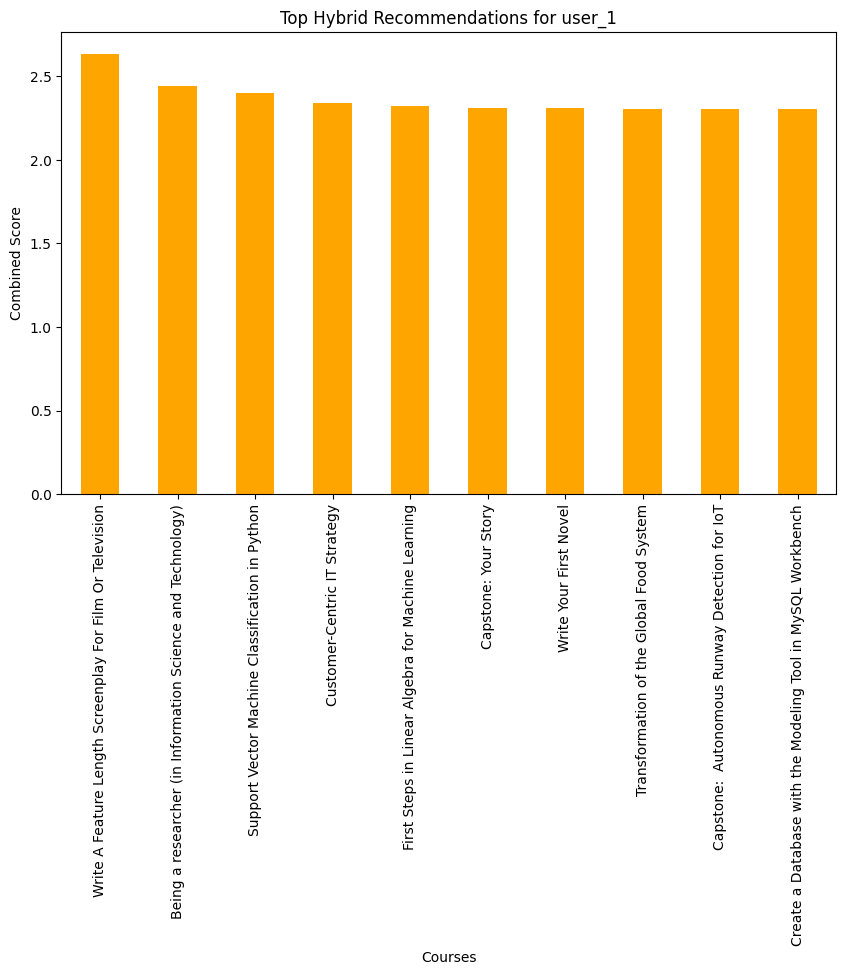

Hybrid Filtering Metrics: Precision=0.39256440281030447, Recall=1.0, F1-Score=0.5638007147361782


In [34]:
# Hybrid Approach Implementation
def hybrid_filtering(collab_recommendations, content_recommendations, alpha=0.5):
    # Combine recommendations using a weighted sum
    combined = collab_recommendations.add(content_recommendations.set_index('Course Name')['similarity'],
                                          fill_value=0)
    combined = combined * alpha + (1 - alpha)
    return combined.sort_values(ascending=False)

hybrid_recommendations = hybrid_filtering(collab_recommendations, content_recommendations)

# Visualize Hybrid Filtering Results
hybrid_recommendations.head(10).plot(kind='bar', figsize=(10, 6), color='orange')
plt.title(f'Top Hybrid Recommendations for {target_user}')
plt.xlabel('Courses')
plt.ylabel('Combined Score')
plt.show()

# Evaluate Hybrid Filtering
# Get predictions for all courses based on whether they are in the top 10 recommendations
hybrid_predictions_all = pd.Series(index=collab_ground_truth.index, dtype=bool)
hybrid_predictions_all.loc[hybrid_recommendations.head(10).index] = True
hybrid_predictions_all.fillna(False, inplace=True)

hybrid_precision = precision_score(collab_ground_truth, hybrid_predictions_all, average='binary')
hybrid_recall = recall_score(collab_ground_truth, hybrid_predictions_all, average='binary')
hybrid_f1 = f1_score(collab_ground_truth, hybrid_predictions_all, average='binary')

print(f"Hybrid Filtering Metrics: Precision={hybrid_precision}, Recall={hybrid_recall}, F1-Score={hybrid_f1}")

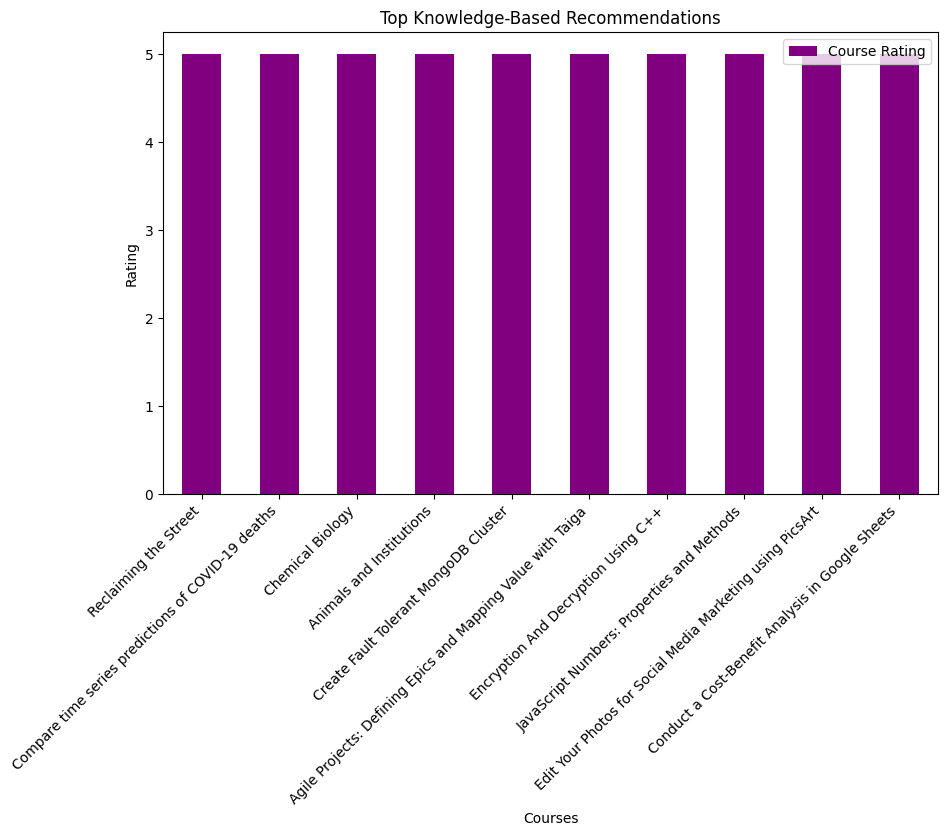

Knowledge-Based Filtering Metrics: Precision=0.9, Recall=1.0, F1-Score=0.9473684210526315


In [35]:
def knowledge_based_filtering(data, user_preferences):
    # Filter courses based on explicit preferences such as 'Course Rating' or 'Difficulty Level'
    # Replace 'stream' and 'subject' with actual column names in your DataFrame.
    # For example, you could filter by 'Course Rating' or 'Difficulty Level'.

    filtered_courses = data

    # Example filtering by 'Course Rating':
    if 'Course Rating' in user_preferences:
        ratings = user_preferences['Course Rating']
        filtered_courses = filtered_courses[filtered_courses['Course Rating'].isin(ratings)]

    # Example filtering by 'Difficulty Level':
    if 'Difficulty Level' in user_preferences:
        difficulty_levels = user_preferences['Difficulty Level']
        filtered_courses = filtered_courses[filtered_courses['Difficulty Level'].isin(difficulty_levels)]

    # Example ranking by 'Course Rating':
    ranked_courses = filtered_courses.sort_values(by='Course Rating', ascending=False)

    return ranked_courses

# Example user preferences
# Example user preferences - Adjusted to match actual columns in data
user_preferences = {
    'Course Rating': [4.5, 4.6, 4.7, 4.8, 4.9, 5.0],  # Example: Filter for ratings above 4.5
    'Difficulty Level': ['Beginner', 'Intermediate']  # Example: Filter for beginner and intermediate levels
}


# Call the function
knowledge_recommendations = knowledge_based_filtering(data, user_preferences)

# Proceed if recommendations exist
if not knowledge_recommendations.empty:
    # Assuming 'Course Name' and 'Course Rating' are relevant columns
    knowledge_recommendations.head(10).plot(x='Course Name', y='Course Rating', kind='bar', figsize=(10, 6), color='purple')
    plt.title('Top Knowledge-Based Recommendations')
    plt.xlabel('Courses')  # Changed label to 'Courses'
    plt.ylabel('Rating')  # Changed label to 'Rating'
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()
else:
    print("No courses found matching the user preferences.")


knowledge_ground_truth = data['Course Rating'] > 4.5  # Example: Courses with ratings above 4.5 are considered relevant
if knowledge_recommendations.empty:
    print("No courses found matching the user preferences. Cannot calculate metrics.")
    knowledge_precision = np.nan
    knowledge_recall = np.nan
    knowledge_f1 = np.nan
else:
    # Align ground truth with predictions
    knowledge_ground_truth_subset = knowledge_ground_truth[knowledge_ground_truth.index.isin(knowledge_recommendations.index)].head(10)  # Select only relevant ground truth entries
    knowledge_predictions = knowledge_recommendations['Course Rating'].head(10) > 4.5

    knowledge_precision = precision_score(knowledge_ground_truth_subset, knowledge_predictions, average='binary', zero_division=1)
    knowledge_recall = recall_score(knowledge_ground_truth_subset, knowledge_predictions, average='binary', zero_division=1)
    knowledge_f1 = f1_score(knowledge_ground_truth_subset, knowledge_predictions, average='binary', zero_division=1)

print(f"Knowledge-Based Filtering Metrics: Precision={knowledge_precision}, Recall={knowledge_recall}, F1-Score={knowledge_f1}")

Collaborative Filtering Metrics:
{'Precision': 0.39256440281030447, 'Recall': 1.0, 'F1-Score': 0.5638007147361782}


<ipython-input-36-7029919138a1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='muted')


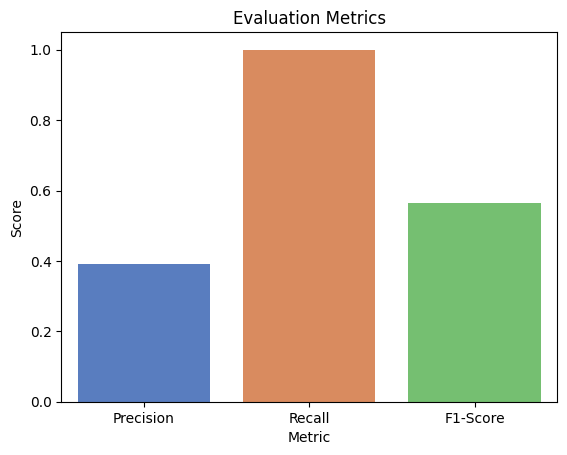

Content-Based Filtering Metrics:
{'Precision': 0.39256440281030447, 'Recall': 1.0, 'F1-Score': 0.5638007147361782}


<ipython-input-36-7029919138a1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='muted')


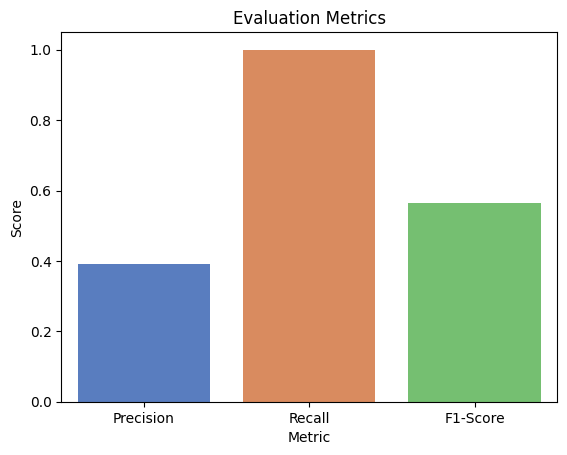

Hybrid Filtering Metrics:
{'Precision': 0.39256440281030447, 'Recall': 1.0, 'F1-Score': 0.5638007147361782}


<ipython-input-36-7029919138a1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='muted')


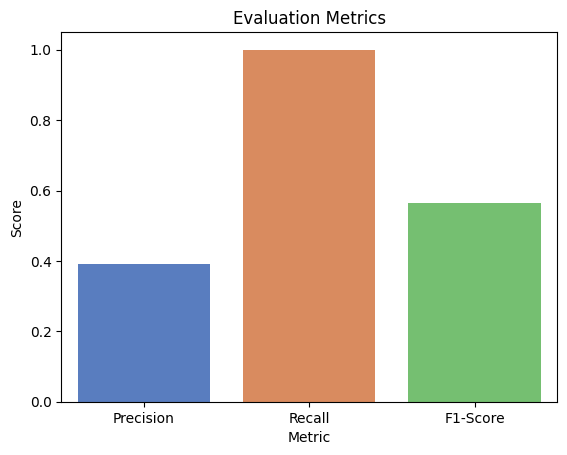

Knowledge-Based Filtering Metrics:
{'Precision': 0.9, 'Recall': 1.0, 'F1-Score': 0.9473684210526315}


<ipython-input-36-7029919138a1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='muted')


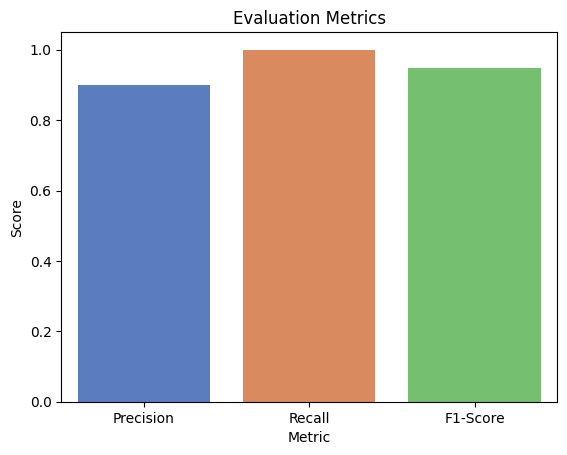

In [36]:
# Visualize Evaluation Metrics
def visualize_metrics(metrics):
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='muted')
    plt.title('Evaluation Metrics')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.show()

# Visualizing evaluation results for all algorithms
all_metrics = {
    'Collaborative': {'Precision': collab_precision, 'Recall': collab_recall, 'F1-Score': collab_f1},
    'Content-Based': {'Precision': content_precision, 'Recall': content_recall, 'F1-Score': content_f1},
    'Hybrid': {'Precision': hybrid_precision, 'Recall': hybrid_recall, 'F1-Score': hybrid_f1},
    'Knowledge-Based': {'Precision': knowledge_precision, 'Recall': knowledge_recall, 'F1-Score': knowledge_f1}
}

for algo, metrics in all_metrics.items():
    print(f"{algo} Filtering Metrics:")
    print(metrics)
    visualize_metrics(metrics)


In [37]:
# Final Ranked Recommendations
def rank_recommendations(recommendations, user_course_matrix, top_n=10):
    return recommendations.head(top_n)

# Generate ranked lists for all users
def generate_ranked_lists(user_course_matrix, data, alpha=0.5, top_n=10):
    ranked_lists = {}
    for user in user_course_matrix.index:
        collab_recs = collaborative_filtering(user_course_matrix, user)
        hybrid_recs = hybrid_filtering(collab_recs, content_based_filtering(data, target_course), alpha)
        ranked_lists[user] = rank_recommendations(hybrid_recs, user_course_matrix, top_n)
    return ranked_lists

all_ranked_courses = generate_ranked_lists(user_course_matrix, data)

# Display ranked courses for each user
for user, courses in all_ranked_courses.items():
    print(f"Top courses for {user}:")
    print(courses)

Top courses for user_1:
Write A Feature Length Screenplay For Film Or Television       2.632746
Being a researcher (in Information Science and Technology)     2.441740
Support Vector Machine Classification in Python                2.397720
Customer-Centric IT Strategy                                   2.340802
First Steps in Linear Algebra for Machine Learning             2.322275
Capstone: Your Story                                           2.312471
Write Your First Novel                                         2.312063
Transformation of the Global Food System                       2.306977
Capstone:  Autonomous Runway Detection for IoT                 2.303854
Create a Database with the Modeling Tool in MySQL Workbench    2.301493
dtype: float64
Top courses for user_2:
Write A Feature Length Screenplay For Film Or Television          2.601884
Being a researcher (in Information Science and Technology)        2.430336
Support Vector Machine Classification in Python                   2